# Improving Text Rendering in Diffusion Models via Auxiliary Loss

This Colab notebook demonstrates a fine-tuning approach for improving text rendering quality in diffusion-based image generation models.

We build on top of **Z-Image-Turbo**, a fast diffusion model, and introduce a **text-aware auxiliary loss** that explicitly guides the model to generate clearer and more consistent text inside images.

The notebook follows three main stages:
1. Environment and dependency setup
2. Fine-tuning the pretrained model with an auxiliary loss
3. Qualitative comparison between the baseline and fine-tuned models

## Environment Setup and Imports

In this section, we prepare the Colab environment for training and inference.

This includes:
- Cloning the project repository
- Installing all required dependencies
- Importing standard, third-party, and project-specific modules
- Configuring the runtime for GPU-based execution

The setup is designed to run on a CUDA-enabled Colab environment and ensures efficient and stable execution of the training pipeline.


In [1]:
!git clone https://github.com/nirrahav/dl-project-text-rendering-diffusion.git
%cd dl-project-text-rendering-diffusion
!pip -q install -r requirements.txt
!pip -q install git+https://github.com/huggingface/diffusers
!pip -q install bitsandbytes



Cloning into 'dl-project-text-rendering-diffusion'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 129 (delta 52), reused 102 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (129/129), 27.53 KiB | 9.18 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/dl-project-text-rendering-diffusion
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 44.1 MB/s eta 0:00:00


In [2]:
# -----------------------
# Standard library
# -----------------------
import os

# -----------------------
# Third-party libraries
# -----------------------
import torch
import matplotlib.pyplot as plt
from diffusers import ZImagePipeline

# -----------------------
# Project imports
# -----------------------
from src.config import TrainConfig
from src.train.finetune_auxloss import train


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


## GPU and PyTorch Configuration

Here we configure the runtime for efficient GPU usage:
- Explicitly select the CUDA device
- Enable optimized CUDA memory allocation
- Activate performance-oriented PyTorch settings

These configurations help ensure stable and efficient training, especially with large diffusion models.


In [3]:
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [4]:
# Reduce CUDA allocator fragmentation (must be set BEFORE torch is imported)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# (optional) be explicit
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


## Model Training Setup and Fine-Tuning

In this section, we initialize the training environment and fine-tune the pretrained diffusion model using an auxiliary text-aware loss.

First, we verify that a CUDA-enabled GPU is available and configure PyTorch for optimal GPU performance.  
This includes setting the active device and enabling performance-related backend optimizations.

Next, we define the training configuration, which specifies:
- The pretrained model identifier (**Z-Image-Turbo**)
- Precision mode (bfloat16) for memory-efficient training
- Image resolution and number of training samples
- Optimization parameters such as learning rate and gradient accumulation
- Auxiliary loss settings, including its weight and application frequency

Finally, we launch the fine-tuning process using the configured settings.  
The training procedure updates only selected model components while preserving the original architecture.


In [6]:
# -----------------------
# GPU availability & configuration
# -----------------------
assert torch.cuda.is_available(), (
    "CUDA is not available. Please set the Colab runtime to use a GPU."
)

torch.cuda.set_device(0)
print("✅ Using GPU:", torch.cuda.get_device_name(0))

# Performance optimizations
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")


# -----------------------
# Training configuration
# -----------------------
cfg = TrainConfig(
    model_id="Tongyi-MAI/Z-Image-Turbo",
    device="cuda:0",
    dtype="bf16",
    image_size=512,
    train_samples=500,
    batch_size=1,
    num_steps=200,
    grad_accum=8,
    lambda_aux=0.2,
    lr=1e-5,
    aux_every=8,
)


# -----------------------
# Run fine-tuning
# -----------------------
train(cfg)


✅ Using GPU: NVIDIA A100-SXM4-80GB


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/model-00001-of-00003.safete(…):   0%|          | 0.00/3.96G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.97G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/4.67G [00:00<?, ?B/s]

transformer/diffusion_pytorch_model-0000(…):   0%|          | 0.00/9.97G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Using AdamW8bit (bitsandbytes)


`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

train: 100%|██████████| 200/200 [02:10<00:00,  1.53it/s, diff=7.52, aux=0, lam=0.2, aux_every=8, dtype=bfloat16]


Saved: checkpoints/transformer_final.pt


## Inference Setup

In this section, we initialize the diffusion pipeline for image generation.

We load the pretrained **Z-Image-Turbo** model using the same precision and device settings as during training.
The pipeline is configured for GPU inference, and progress bars are disabled for cleaner output.

A fixed set of prompts is defined to ensure a consistent and fair comparison between the baseline and the fine-tuned models.


In [7]:
device = "cuda"
dtype = torch.bfloat16

pipe = ZImagePipeline.from_pretrained(
    "Tongyi-MAI/Z-Image-Turbo",
    torch_dtype=dtype,
    low_cpu_mem_usage=False
).to(device)

pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Baseline and Fine-Tuned Image Generation

In this section, we generate images using the same diffusion pipeline in two different settings:
1. The original pretrained model (baseline)
2. The model after fine-tuning with the auxiliary loss

---

### Baseline Generation

We first generate images using the original **Z-Image-Turbo** model without any fine-tuned weights.
This establishes a reference point for evaluating text rendering quality.

All baseline images are generated using:
- Identical prompts
- The same number of inference steps
- The original pretrained weights

---

### Loading Fine-Tuned Weights

Next, we load the transformer weights obtained after the fine-tuning process.

Only the transformer component of the pipeline is updated, while the rest of the diffusion model remains unchanged.
This ensures that any observed improvements are the result of the modified training objective, rather than architectural changes.

---

### Fine-Tuned Generation

Finally, we generate images again using the same prompts and inference settings, but with the fine-tuned weights applied.

This controlled setup allows a direct qualitative comparison between the baseline and fine-tuned outputs, isolating the effect of the auxiliary text-aware loss.


In [8]:
# -----------------------
# Prompts & inference setup
# -----------------------
prompts = [
    'A clean poster with the text "OPEN TODAY" in bold, perfectly readable letters.',
    'A street sign that says "MAIN STREET" in clear black capital letters.',
    'A coffee shop logo with the word "LATTE" centered, sharp and readable.',
]

num_steps = 8


# -----------------------
# Helper function
# -----------------------
def generate_images(pipe, prompts, num_steps):
    images = []
    with torch.no_grad():
        for prompt in prompts:
            img = pipe(
                prompt=prompt,
                num_inference_steps=num_steps
            ).images[0]
            images.append(img)
    return images


# -----------------------
# Baseline generation
# -----------------------
baseline_images = generate_images(
    pipe=pipe,
    prompts=prompts,
    num_steps=num_steps
)


# -----------------------
# Load fine-tuned weights
# -----------------------
ckpt_path = "checkpoints/transformer_final.pt"
state = torch.load(ckpt_path, map_location=device)

pipe.transformer.load_state_dict(state, strict=False)
pipe.transformer.eval()


# -----------------------
# Fine-tuned generation
# -----------------------
finetuned_images = generate_images(
    pipe=pipe,
    prompts=prompts,
    num_steps=num_steps
)


## Visual Comparison: Baseline vs Fine-Tuned

Finally, we visualize the baseline and fine-tuned outputs side by side.

For each prompt:
- The left image corresponds to the baseline model
- The right image corresponds to the fine-tuned model

The comparison focuses on text readability, alignment, and overall visual consistency.


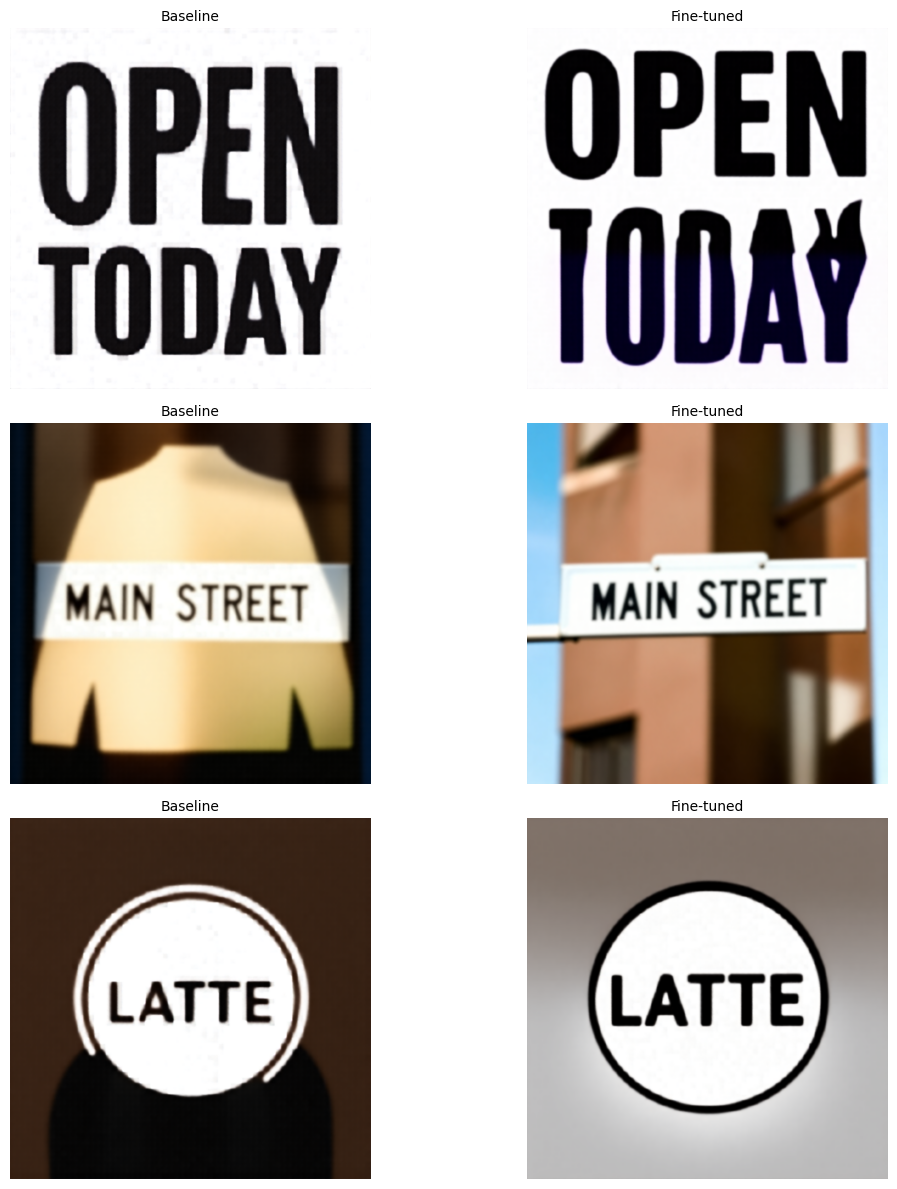

In [9]:
n = len(prompts)
plt.figure(figsize=(12, 4 * n))

for i, prompt in enumerate(prompts):
    plt.subplot(n, 2, 2*i + 1)
    plt.title(f"Baseline", fontsize=10)
    plt.imshow(baseline_images[i])
    plt.axis("off")

    plt.subplot(n, 2, 2*i + 2)
    plt.title(f"Fine-tuned", fontsize=10)
    plt.imshow(finetuned_images[i])
    plt.axis("off")

plt.tight_layout()
plt.show()